In [1]:
using Revise

using RigidBodyDynamics
using RigidBodyDynamics: Bounds

using DrakeVisualizer
using Plots
using RigidBodyTreeInspector

using BilevelTrajOpt
gr(size=(500,500), html_output_format=:png);

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9dd84cf97c4fc16956f39829c81f3b6907c8fc83-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9dd84cf97c4fc16956f39829c81f3b6907c8fc83-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [2]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)
body = findbody(mechanism, "ball")
basejoint = joint_to_parent(body, mechanism)
floatingjoint = Joint(basejoint.name, frame_before(basejoint), frame_after(basejoint), QuaternionFloating{Float64}())
replace_joint!(mechanism, basejoint, floatingjoint)
position_bounds(floatingjoint) .= Bounds(-100, 100)
velocity_bounds(floatingjoint) .= Bounds(-100, 100)
μ = 0.5
motion_type = :xyz
point = Point3D(default_frame(findbody(mechanism, "floor")), [0.,0.,0.])
normal = FreeVector3D(default_frame(findbody(mechanism, "floor")), [0.,0.,1.])
hs = HalfSpace(point, normal)
floor = Obstacle(hs, μ, motion_type)
obstacles = [floor]
env = parse_contacts(mechanism, urdf, obstacles)
x0 = MechanismState(mechanism)
Δt = 0.005;

In [ ]:
q0 = [1., 0., 0., 0., 0., 0., 0.0025]
v0 = [0., 0., 0., .25, 0. , 0.]
N = 5

set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)

ctrl! = (u,t,x) -> u[:] = 0.

println("Implicit Contacts")
traj_imp = BilevelTrajOpt.simulate(x0,env,Δt,N,ctrl!,implicit_contact=true);

In [14]:
println("Explicit Contacts")
traj_exp = BilevelTrajOpt.simulate(x0,env,Δt,N,ctrl!,implicit_contact=false);

Explicit Contacts
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded


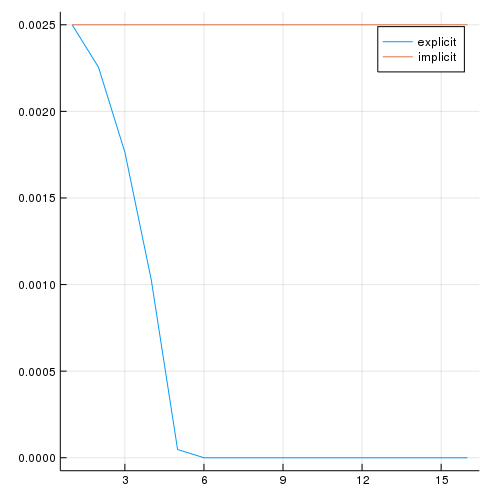

In [16]:
ts = cumsum([Δt for i in 1:N]);
j = 7
plot(traj_exp[j,:],label="explicit")
plot!(traj_imp[j,:],label="implicit")

In [13]:
traj_imp

19×16 Array{Float64,2}:
 1.0      1.0           1.0          …   1.0           1.0        
 0.0      0.0           0.0              0.0           0.0        
 0.0      0.0           0.0              0.0           0.0        
 0.0      0.0           0.0              0.0           0.0        
 0.0      0.00125       0.0025           0.0175        0.01875    
 0.0     -1.94666e-15  -5.83999e-15  …  -2.044e-13    -2.33599e-13
 0.0025   0.0025        0.0025           0.0025        0.0025     
 0.0      0.0           0.0              0.0           0.0        
 0.0      0.0           0.0              0.0           0.0        
 0.0      0.0           0.0              0.0           0.0        
 0.25     0.25          0.25         …   0.25          0.25       
 0.0     -3.89333e-13  -7.78665e-13     -5.45065e-12  -5.83999e-12
 0.0      8.21161e-11   1.64232e-10      1.14963e-9    1.23174e-9 
 0.0      0.0           0.0              0.0           0.0        
 0.0      0.0           0.0           